In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the data

In [7]:
data = pd.read_csv('arranged_mathData.csv')

In [8]:
data.shape

(395, 33)

In [9]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


#### Check if data is missed

In [10]:
data.isnull().values.any()

False

In [11]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## Visualisation of data

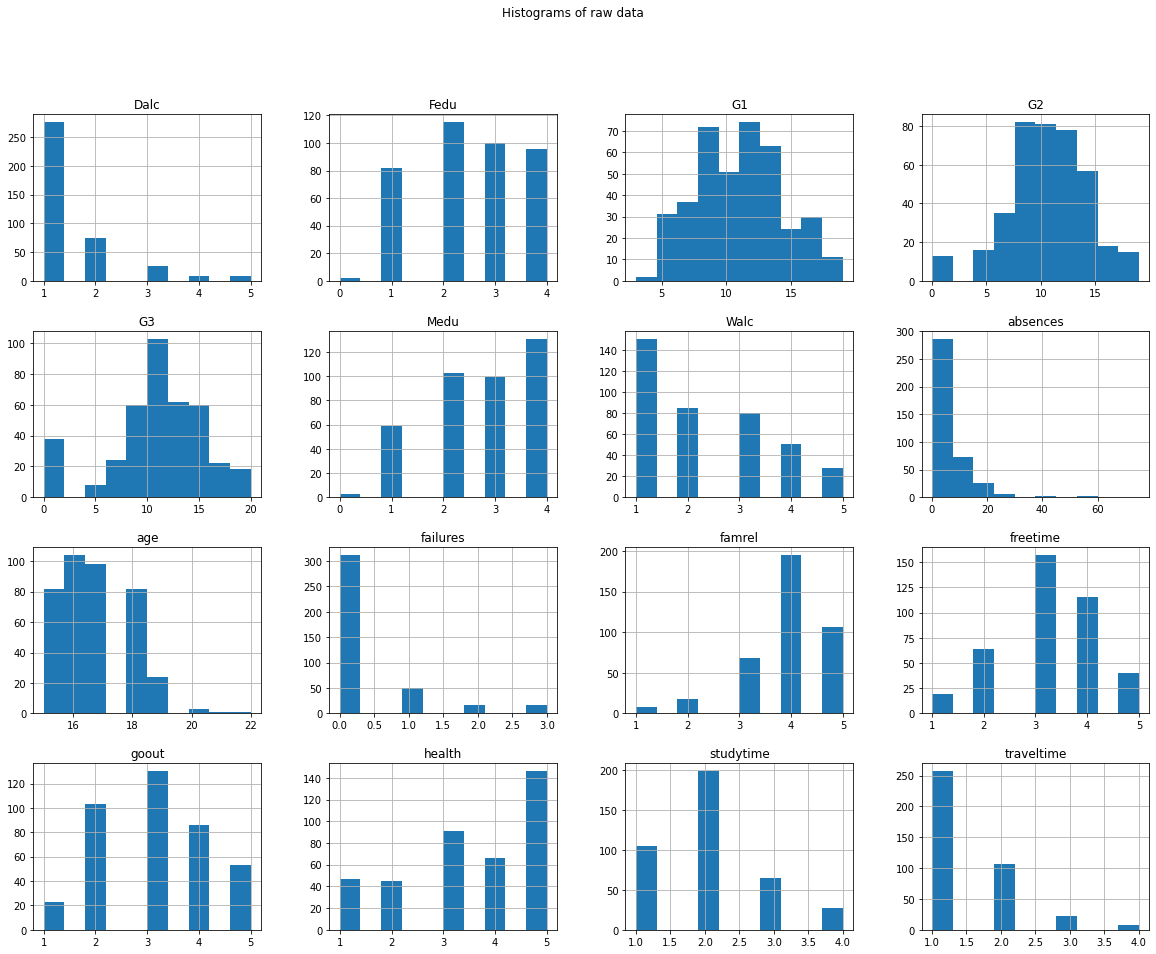

In [12]:
data.hist(figsize=(20, 15))
plt.suptitle('Histograms of raw data')
plt.show()

### Dummify the categorical features

In [13]:
#Dumify Bool Values and Take only One Column For them 
data =pd.get_dummies(data,columns=['school', 'sex', 'address', 'famsize', 
                                      'Pstatus','schoolsup','famsup', 'paid', 
                                      'activities','nursery', 'higher', 'internet', 
                                      'romantic'],drop_first=True) 
#Dumify Categorical Values 
data =pd.get_dummies(data,columns=['Mjob', 'Fjob', 'reason', 'guardian'])

In [14]:
data.shape

(395, 46)

In [15]:
data.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'schoolsup_yes', 'famsup_yes', 'paid_yes', 'activities_yes',
       'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other'],
      dtype='object')

output target is G3

In [16]:
X = data.loc[:, data.columns != 'G3']
y = data['G3']

In [17]:
X.shape, y.shape

((395, 45), (395,))

## Train Test Split

The data has 395 examples, So, we split the data with 70% train and 30% test.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Standeridation the data prior to PCA so to make the other components contribute in variance. The reason for this is because PCA seeks to maximize the variance of each component. The training data is used to fit the scaler object and the use the parameters of scaling from train data to scale the test data.

scaled_train =  (train - train_mean) / train_std_deviation

scaled_test = (test - train_mean) / train_std_deviation


In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## PCA

N.B. Principal Componenets Analysis were not used here, so we did feature selection on the original standerdized data.

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=45)
pca.fit(X_train_std)
cum_var = pca.explained_variance_ratio_.cumsum()

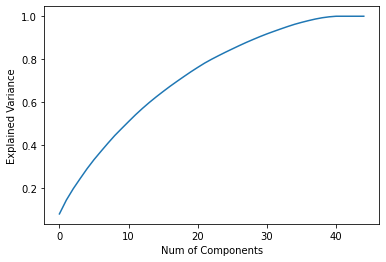

In [23]:
plt.plot(cum_var)
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.show()

Number of componenets to be used is 40 components

In [24]:
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

However, PCA was not used here, so we did feature selection on the original standerdized data.

## Forward Sequential Feature Selection

It was decided to stick to only 13 features, after 13 features, the performance curve flatten and then declines again, The calculation was done on linear model.

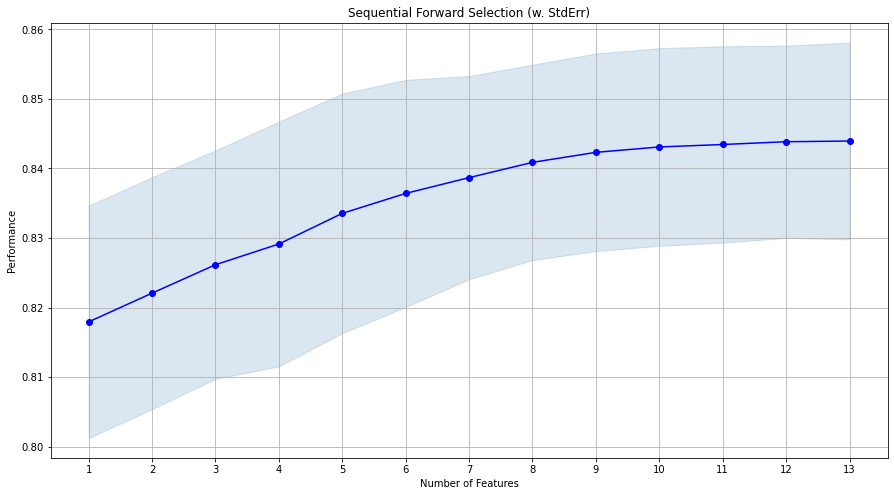

In [25]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# Initialise Sequential Feature Selector
sfs1 = SFS(lr, 
           k_features=13, 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=10)

# Fit models
sfs1 = sfs1.fit(X_train_std, y_train)

# This dictionary contains results from all compuations
metric_dict = sfs1.get_metric_dict()
# Get indices of best features
k_ind = sfs1.k_feature_idx_

# Get names of best features using numpy arrays
feature_names = X.columns


# Plot the score vs the feature index
fig = plot_sfs(metric_dict, kind='std_err', figsize=(15, 8))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

Here, we take only the features we need from the train data.

In [26]:
X_test_selected_features = X_test_std[:, k_ind]
X_train_selected_features = X_train_std[:, k_ind]

## Partial Least Square Regression

In [27]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

pls = PLSRegression(n_components=7)

pls_r2 = cross_val_score(pls, X_train_selected_features, y_train, cv=10, scoring='r2')
pls_mse = cross_val_score(pls, X_train_selected_features, y_train, cv=10, scoring= make_scorer(mean_squared_error)) 

In [28]:
np.mean(pls_r2)

0.8439540941114391

In [29]:
np.mean(pls_mse)

3.0746935522173966

How to decide number of componenets to use the PLS,  after number of components=7, the curve flattens

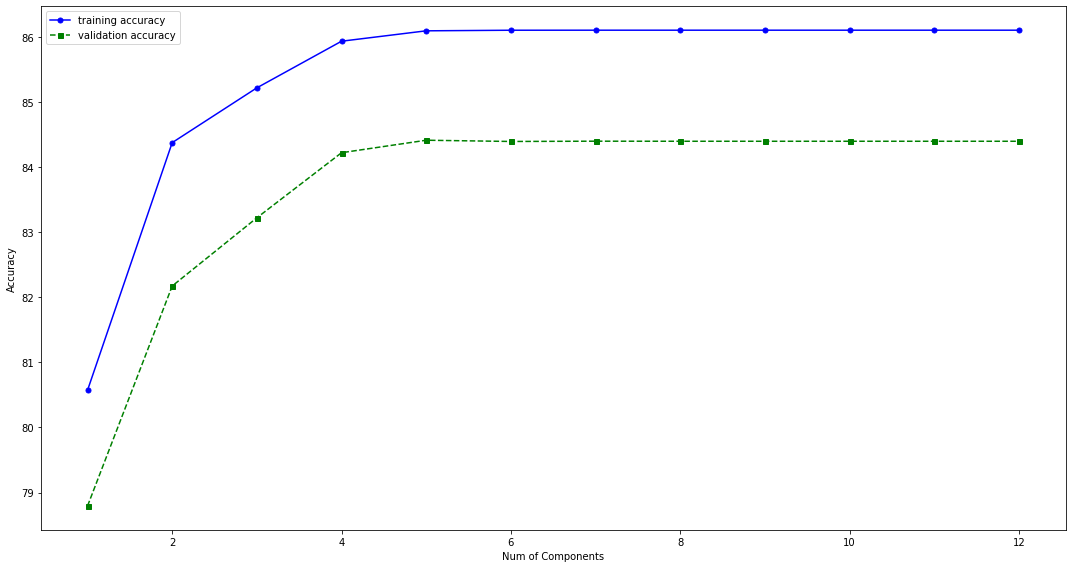

[78.79288845 82.17161006 83.21898819 84.21840097 84.41019004 84.39116262
 84.39540941 84.39428401 84.39424284 84.39427812 84.39427878 84.39427853]


In [30]:
from sklearn.model_selection import validation_curve

pls = PLSRegression()

# Validation curve for parameter estimation
param_range = list(range(1,13))

train_scores, test_scores = validation_curve(
                estimator=pls, 
                X=X_train_selected_features, 
                y=y_train, 
                param_name='n_components',
                param_range=param_range,
                cv=10)

# Calculate validation curves for training and test sets
train_mean = np.mean(train_scores, axis=1)*100
train_std = np.std(train_scores, axis=1)*100
test_mean = np.mean(test_scores, axis=1)*100
test_std = np.std(test_scores, axis=1)*100

plt.figure(figsize=(15, 8))

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.grid()
plt.legend()
plt.xlabel('Num of Components')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.show()
print(test_mean)

## Training

In [31]:
pls.fit(X_train_selected_features, y_train)
y_pred = pls.predict(X_test_selected_features)

## Scatter Graphs for Prediction vs Actual

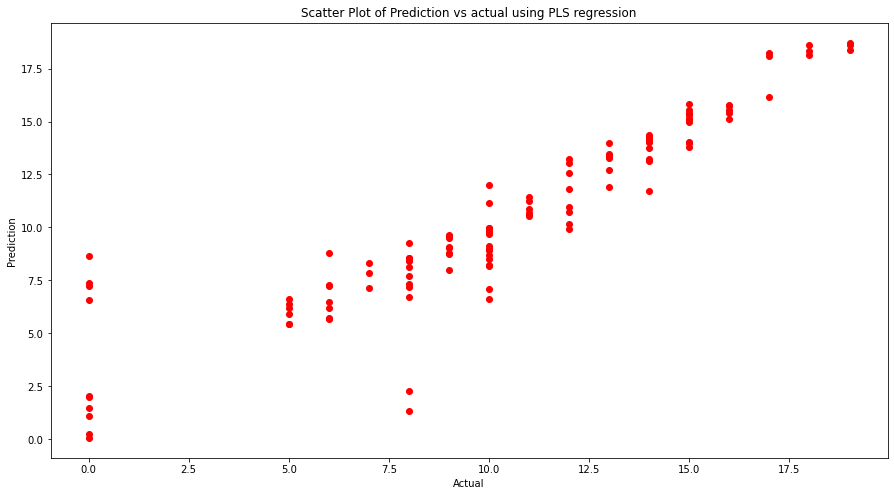

In [45]:
plt.figure(figsize=(15, 8))
plt.scatter(y_test, y_pred, color = "red")
plt.title("Scatter Plot of Prediction vs actual using PLS regression")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.show()

In [33]:
print(pls.score(X_test_selected_features, y_test))

0.7563993182947681


## RandomForestRegressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse',
                               random_state=1, 
                               n_jobs=-1)
forest_r2 = cross_val_score(forest, X_train_selected_features, y_train, cv=20, scoring='r2')
forest_mse = cross_val_score(forest, X_train_selected_features, y_train, cv=20, scoring= make_scorer(mean_squared_error)) 

Mean of R2 Score

In [36]:
np.mean(forest_r2)

0.8993451741152283

Mean value of Mean Square Error

In [37]:
np.mean(forest_mse)

1.8307159340659336

Training the Random Forest Regressor, and prediction

In [38]:
forest.fit(X_train_selected_features, y_train)
y_pred = forest.predict(X_test_selected_features)

Scatter plot of the actual data vs the predicted data

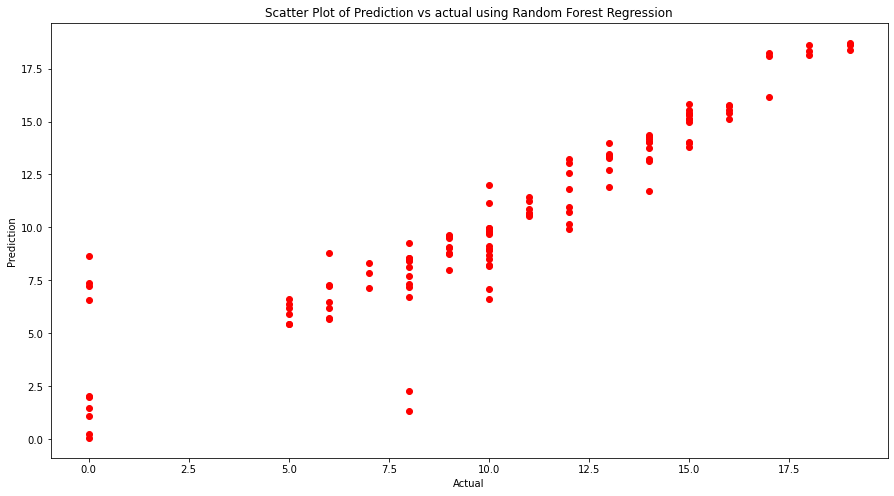

In [43]:
plt.figure(figsize=(15, 8))
plt.scatter(y_test, y_pred, color = "red")
plt.title("Scatter Plot of Prediction vs actual using Random Forest Regression")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.show()

In [40]:
print(forest.score(X_test_selected_features, y_test))

0.8410067747552106


## References

https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca

https://archive.ics.uci.edu/ml/datasets/student+performance

https://www.researchgate.net/post/Is_it_necessary_to_normalize_data_before_performing_principle_component_analysis

https://sebastianraschka.com/faq/docs/scale-training-test.html

https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

https://www.researchgate.net/post/Is_it_advisable_to_use_a_dummy_variable_for_sex_male_female_in_my_regression_analysis

https://bookdown.org/ripberjt/labbook/categorical-explanatory-variables-dummy-variables-and-interactions.html